In [1]:
''' Module Import'''
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision
from torchvision import transforms, datasets

In [2]:
''' 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using PyTorch version: {torch.__version__}, Device: {DEVICE}')
BATCH_SIZE = 16
EPOCHS = 10

Using PyTorch version: 1.8.1, Device: cuda


In [3]:
''' 이미지 transform'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [4]:
''' CIFAR10 데이터 다운로드(Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = './data/CIFAR_10', 
                                      train = True, 
                                      download = True,
                                      transform = transform) 

test_dataset = datasets.CIFAR10(root = './data/CIFAR_10',
                                      train = False,
                                      download = True,
                                      transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
                                                
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

In [6]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print(f'X_train: {X_train.size()}, type: {X_train.type()}')
    print(f'y_train: {y_train.size()}, type: {y_train.type()}')
    break

X_train: torch.Size([16, 3, 32, 32]), type: torch.FloatTensor
y_train: torch.Size([16]), type: torch.LongTensor


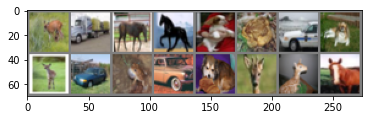

 deer truck horse horse   dog  forg   car   dog  deer   car  forg   car   dog  deer  deer horse


In [7]:
classes = ('plane','car','bird','cat','deer','dog','forg','horse','ship','truck')

''' 데이터 확인하기 (2) '''
def imshow(img):
    img = (img+1) / 2
    nping = img.numpy()
    plt.imshow(np.transpose(nping, (1,2,0)))
    plt.show()
    

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'%classes[labels[j]] for j in range(16)))

In [8]:
''' 모델설계 '''
class VGG(nn.Module):
    def __init__(self, features, num_classes=10, init_weights=True):
        super(VGG, self).__init__()        
        self.features = features #convolution        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )#FC layer
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)   #Convolution 
        x = x.view(x.size(0), -1) #
        x = self.classifier(x) #FC layer
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # Conv2d layer 가중치 초기화
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1) # BatchNorm Normalization 가중치 초기화 
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01) # FC layer 가중치 초기화  
                nn.init.constant_(m.bias, 0)

In [9]:
# VGG 16 네트워크의 Out_channel 수 
# 사용자가 custom 가능 
cfg = [32,32,'M',64,64,128,128,128,'M',256,256,256,512,512,512,'M'] #13 + 3 = vgg16

In [10]:
# architecture가 발전할수록 층이 점점 많아짐 => 기존처럼 layer마다 층을 쌓는건 비효율적
# 이 방법은 cfg라는 output_channel의 집합인 리스트를 만들어서 반복문으로 접근하여 layer를 쌓음
# M일 경우 Maxpooling을 진행하고 그렇지 않은 경우에는 Conv2d층을 추가함 (만일 batch_norm=True일 경우 BN을 추가)
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)] # layers에 conv2d와 BN와 Relu를 차례대로 추가
            else:
                layers += [conv2d, nn.ReLU(inplace=True)] # layers에 conv2d와 Relu만 추가 
            in_channels = v
                     
    return nn.Sequential(*layers)

In [11]:
make_layers(cfg,batch_norm=True)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [12]:
vgg16 = VGG(make_layers(cfg,batch_norm=True), num_classes=10, init_weights=True)

In [13]:
''' 7. Optimizer, Objective function 설정하기 '''
model = vgg16.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, eps=1e-05, 

In [14]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train() 
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        # ------------- forward propagation
        optimizer.zero_grad()
        output = model(image)
        # ------------- backward propagation
        loss = criterion(output, label)
        loss.backward() 
        optimizer.step() 
        
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {Epoch} \
                    [{batch_idx * len(image)} / {len(train_loader.dataset)}] ({batch_idx / len(train_loader) * 100:.0f}%) \
                    Train Loss: {loss.item():.6f}')

In [15]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval() 
    test_loss = 0 
    correct = 0 
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            
            test_loss += criterion(output, label).item() 
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset) * 100
    return test_loss, test_accuracy

In [16]:
''' 10. MLP 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f'[EPOCH: {Epoch}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}]')

RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 2.00 GiB total capacity; 892.74 MiB already allocated; 93.44 MiB free; 948.00 MiB reserved in total by PyTorch)

In [ ]:
# 라벨(숫자) -> 단어(문자)로 변환하기 위한 dictionary생성
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# 이미지 생성 함수 
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [ ]:
# 테스트를 위해 test 데이터에서 image와 label 일부 가져옴 
dataiter = iter(test_loader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(32)))

In [17]:
# 훈련된 모델에 추출한 이미지 넣기
outputs = model(images.to(DEVICE))

# 예측값 (라벨) 뽑기
_, predicted = torch.max(outputs, 1)

# 'GroundTruth'와 predicted 비교 ( = 실제와 예측 비교 )
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(32)))

IndexError: index 16 is out of bounds for dimension 0 with size 16

In [113]:
# 각 라벨별 정확도를 산출
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 92 %
Accuracy of  bird : 39 %
Accuracy of   cat : 39 %
Accuracy of  deer : 74 %
Accuracy of   dog : 55 %
Accuracy of  frog : 67 %
Accuracy of horse : 70 %
Accuracy of  ship : 92 %
Accuracy of truck : 84 %
